In [1]:
! pip install tslearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.utils import to_time_series_dataset
from sklearn.cluster import KMeans
import itertools

     |████████████████████████████████| 793 kB 5.0 MB/s 


/usr/local/lib/python3.7/dist-packages/tslearn/clustering/kmeans.py:17: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  "Scikit-learn <0.24 will be deprecated in a "


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train = pd.read_csv('/content/drive/MyDrive/input/kaggle_google_brain_ventilator_pressure/train.csv')
test = pd.read_csv('/content/drive/MyDrive/input/kaggle_google_brain_ventilator_pressure/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/input/kaggle_google_brain_ventilator_pressure/sample_submission.csv')


train_for_all = train.drop("pressure",axis=1)
train_for_all['train_test'] = 'train'
test['train_test'] = 'test'
df_all = pd.concat([train_for_all,test],axis=0)

In [4]:
train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [5]:
test.head()

,id,breath_id,R,C,time_step,u_in,u_out,train_test
0,1,0,5,20,0.000000,0.000000,0,test
1,2,0,5,20,0.031904,7.515046,0,test
2,3,0,5,20,0.063827,14.651675,0,test
3,4,0,5,20,0.095751,21.230610,0,test
4,5,0,5,20,0.127644,26.320956,0,test


In [6]:
def grouping_describe(df, key_describe_cols, stat_describe_cols, agg_describe_kinds):
      
    """
    統計値を取得する

    Args:
        df(DataFrame):前処理するデータ
        agg_describe_kinds(リスト):統計リスト
        
    Returns:
        df(DataFrame)
        
    """  
        
    for key_col, agg_kind, stat_col in itertools.product(key_describe_cols, agg_describe_kinds, stat_describe_cols):
        
        df['breath_id__' + stat_col + '__' + agg_kind] = df.groupby([key_col])[stat_col].transform(agg_kind)
        
    return df

In [7]:
def grouping_cumsum(df, stat_cumsum_cols):
    """
    cumsumを取得する

    Args:
        df(DataFrame):前処理するデータ
        stat_cumsum_cols(リスト):cumsumするリスト
        
    Returns:
        df(DataFrame)
        
    """  

    for stat_col in stat_cumsum_cols:
        
        df[stat_col + '_cumsum'] = df.groupby('breath_id')[stat_col].cumsum()

    return df

In [8]:
df_all_des = df_all.copy()
df_all_des['u_in_max'] = df_all_des.groupby('breath_id')['u_in'].transform('max') 
df_all_des['u_in'] = df_all_des['u_in']/df_all_des['u_in_max']
# df_all_des = df_all_des[df_all_des['time_step'] < 1.0]

df_all_des['u_in_lag1'] = df_all_des['u_in'].shift(1)
df_all_des['u_in_lag2'] = df_all_des['u_in'].shift(2)
df_all_des['u_in_lag_back1'] = df_all_des['u_in'].shift(-1)
df_all_des['u_in_lag_back2'] = df_all_des['u_in'].shift(-2)
df_all_des['u_in_diff1'] = df_all_des['u_in'] - df_all_des['u_in_lag1']
df_all_des['u_in_diff2'] = df_all_des['u_in'] - df_all_des['u_in_lag2']
df_all_des = df_all_des.fillna(0)

print('***********************************************************************************')
print('preprocessing...grouping_describe')
# breath_idごとに統計値を算出する
# df.groupby(['breath_id'])[stat_col].transform(agg_kind)

key_describe_cols = [
    'breath_id'
]

stat_describe_cols = [
  'u_in',
  # 'u_out',
  # 'u_in_lag1',
  # 'u_in_lag2',
  # 'u_in_lag_back1',
  # 'u_in_lag_back2',
  'u_in_diff1',
  'u_in_diff2'
]

agg_describe_kinds = [
  'max',
  'min',
  'mean', 
  'std',  
  'sum' 
]

df_all_des = grouping_describe(df_all_des, key_describe_cols, stat_describe_cols, agg_describe_kinds)
print('finished')
print('***********************************************************************************')


print('***********************************************************************************')
print('preprocessing...grouping_cumsum')
# breath_id毎に累積和を計算する
# df.groupby('breath_id')[stat_col].cumsum()

stat_cumsum_cols = [
  'u_in',
  # 'u_out',
  # 'u_in_lag1',
  # 'u_in_lag2',
  # 'u_in_lag_back1',
  # 'u_in_lag_back2',
  'u_in_diff1',
  'u_in_diff2'
]

df_all_des = grouping_cumsum(df_all_des, stat_cumsum_cols)

print('finished')
print('***********************************************************************************')

df_all_des = pd.get_dummies(df_all_des, columns = ['R', 'C'])

grouped_df_all = df_all_des.groupby(['train_test', 'breath_id']).mean().reset_index(drop = False).drop(columns = ['id'])
grouped_df_all.head()

***********************************************************************************
preprocessing...grouping_describe
finished
***********************************************************************************
***********************************************************************************
preprocessing...grouping_cumsum
finished
***********************************************************************************


,train_test,breath_id,time_step,u_in,u_out,u_in_max,u_in_lag1,u_in_lag2,u_in_lag_back1,u_in_lag_back2,u_in_diff1,u_in_diff2,breath_id__u_in__max,breath_id__u_in_diff1__max,breath_id__u_in_diff2__max,breath_id__u_in__min,breath_id__u_in_diff1__min,breath_id__u_in_diff2__min,breath_id__u_in__mean,breath_id__u_in_diff1__mean,breath_id__u_in_diff2__mean,breath_id__u_in__std,breath_id__u_in_diff1__std,breath_id__u_in_diff2__std,breath_id__u_in__sum,breath_id__u_in_diff1__sum,breath_id__u_in_diff2__sum,u_in_cumsum,u_in_diff1_cumsum,u_in_diff2_cumsum,R_5,R_20,R_50,C_10,C_20,C_50
0,test,0,1.260038,0.248449,0.6125,37.542219,0.247520,0.246489,0.260949,0.267299,0.000929,0.001960,1.0,0.200176,0.390272,0.000000,-0.084777,-0.167278,0.248449,0.000929,0.001960,0.324428,0.053196,0.101418,19.875943,0.074337,0.156788,14.596574,0.190312,0.387932,1,0,0,0,1,0
1,test,8,1.344447,0.254183,0.6375,16.140384,0.251975,0.249768,0.254183,0.255191,0.002208,0.004415,1.0,0.867526,0.867649,0.000000,-0.471536,-0.226287,0.254183,0.002208,0.004415,0.218820,0.217379,0.128465,20.334656,0.176617,0.353228,11.559405,0.121709,0.241333,1,0,0,0,0,1
2,test,11,1.361279,0.128103,0.6375,33.717608,0.130117,0.132130,0.116753,0.109901,-0.002014,-0.004027,1.0,0.690909,0.691037,0.000000,-0.211231,-0.409210,0.128103,-0.002014,-0.004027,0.151527,0.092988,0.132232,10.248229,-0.161125,-0.322183,6.002319,-0.180988,-0.359834,0,0,1,1,0,0
3,test,24,1.338484,0.476459,0.6250,13.088876,0.477438,0.478424,0.487810,0.492076,-0.000978,-0.001965,1.0,0.177084,0.353570,0.068772,-0.179669,-0.358168,0.476459,-0.000978,-0.001965,0.317819,0.070827,0.131977,38.116754,-0.078248,-0.157192,24.563146,0.328493,0.658026,0,0,1,1,0,0
4,test,31,1.343906,0.110516,0.6375,100.000000,0.110764,0.111002,0.098570,0.094733,-0.000248,-0.000487,1.0,0.930281,0.931040,0.000000,-0.482513,-0.879165,0.110516,-0.000248,-0.000487,0.175405,0.202807,0.233685,8.841262,-0.019831,-0.038925,6.662204,0.040797,0.082601,0,1,0,0,0,1


1
2
3
4
5
6
7
8
9


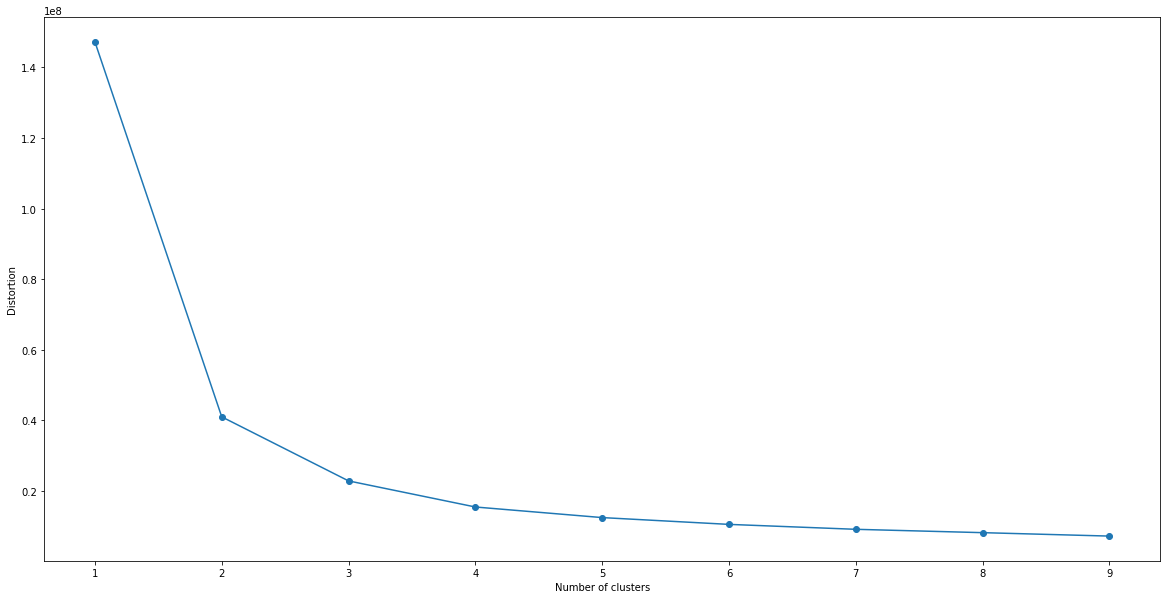

In [9]:
distortions = []
max_clu = 10

for i  in range(1,max_clu):                # 1~10クラスタまで一気に計算 
  print(i)
  km = KMeans(n_clusters=i,
              init='k-means++',     # k-means++法によりクラスタ中心を選択
              n_init=10,
              max_iter=300,
              random_state=0)
  km.fit(grouped_df_all.drop(columns = ['breath_id', 'train_test', 'time_step']))  # クラスタリングの計算を実行
  distortions.append(km.inertia_)   # km.fitするとkm.inertia_が得られる
 
plt.figure(figsize = (20, 10))
plt.plot(range(1,max_clu),distortions,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [10]:
cls = KMeans(max_iter = 10000, n_init = 10, n_clusters = 4)

In [11]:
cls.fit(grouped_df_all.drop(columns = ['breath_id', 'train_test', 'time_step']))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=10000,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [12]:
cls.inertia_

15485098.12669941

In [13]:
pred=cls.predict(grouped_df_all.drop(columns = ['breath_id', 'train_test', 'time_step']))

In [14]:
grouped_df_all['cluster_no'] = cls.labels_

In [15]:
grouped_df_all.head(10)

,train_test,breath_id,time_step,u_in,u_out,u_in_max,u_in_lag1,u_in_lag2,u_in_lag_back1,u_in_lag_back2,u_in_diff1,u_in_diff2,breath_id__u_in__max,breath_id__u_in_diff1__max,breath_id__u_in_diff2__max,breath_id__u_in__min,breath_id__u_in_diff1__min,breath_id__u_in_diff2__min,breath_id__u_in__mean,breath_id__u_in_diff1__mean,breath_id__u_in_diff2__mean,breath_id__u_in__std,breath_id__u_in_diff1__std,breath_id__u_in_diff2__std,breath_id__u_in__sum,breath_id__u_in_diff1__sum,breath_id__u_in_diff2__sum,u_in_cumsum,u_in_diff1_cumsum,u_in_diff2_cumsum,R_5,R_20,R_50,C_10,C_20,C_50,cluster_no
0,test,0,1.260038,0.248449,0.6125,37.542219,0.247520,0.246489,0.260949,0.267299,0.000929,0.001960,1.0,0.200176,0.390272,0.000000,-0.084777,-0.167278,0.248449,0.000929,0.001960,0.324428,0.053196,0.101418,19.875943,0.074337,0.156788,14.596574,0.190312,0.387932,1,0,0,0,1,0,3
1,test,8,1.344447,0.254183,0.6375,16.140384,0.251975,0.249768,0.254183,0.255191,0.002208,0.004415,1.0,0.867526,0.867649,0.000000,-0.471536,-0.226287,0.254183,0.002208,0.004415,0.218820,0.217379,0.128465,20.334656,0.176617,0.353228,11.559405,0.121709,0.241333,1,0,0,0,0,1,3
2,test,11,1.361279,0.128103,0.6375,33.717608,0.130117,0.132130,0.116753,0.109901,-0.002014,-0.004027,1.0,0.690909,0.691037,0.000000,-0.211231,-0.409210,0.128103,-0.002014,-0.004027,0.151527,0.092988,0.132232,10.248229,-0.161125,-0.322183,6.002319,-0.180988,-0.359834,0,0,1,1,0,0,3
3,test,24,1.338484,0.476459,0.6250,13.088876,0.477438,0.478424,0.487810,0.492076,-0.000978,-0.001965,1.0,0.177084,0.353570,0.068772,-0.179669,-0.358168,0.476459,-0.000978,-0.001965,0.317819,0.070827,0.131977,38.116754,-0.078248,-0.157192,24.563146,0.328493,0.658026,0,0,1,1,0,0,0
4,test,31,1.343906,0.110516,0.6375,100.000000,0.110764,0.111002,0.098570,0.094733,-0.000248,-0.000487,1.0,0.930281,0.931040,0.000000,-0.482513,-0.879165,0.110516,-0.000248,-0.000487,0.175405,0.202807,0.233685,8.841262,-0.019831,-0.038925,6.662204,0.040797,0.082601,0,1,0,0,0,1,1
5,test,33,1.363203,0.427964,0.6375,16.276426,0.424755,0.421547,0.439392,0.448454,0.003209,0.006417,1.0,0.230688,0.425612,0.000000,-0.841476,-0.869093,0.427964,0.003209,0.006417,0.364631,0.104939,0.160773,34.237091,0.256718,0.513343,22.013289,0.378076,0.752965,0,0,1,0,0,1,0
6,test,38,1.260170,0.193026,0.6125,61.741589,0.195852,0.198677,0.181044,0.168544,-0.002826,-0.005651,1.0,0.651964,0.693395,0.000000,-0.075431,-0.128027,0.193026,-0.002826,-0.005651,0.267986,0.077479,0.116921,15.442078,-0.226066,-0.452096,12.178004,-0.113579,-0.224219,1,0,0,0,1,0,2
7,test,45,1.269274,0.482589,0.6125,4.975613,0.471096,0.459612,0.489712,0.498771,0.011493,0.022977,1.0,0.384727,0.579991,0.000000,-0.642366,-0.684794,0.482589,0.011493,0.022977,0.401113,0.104204,0.171338,38.607134,0.919461,1.838151,13.274561,0.402050,0.792684,0,0,1,0,1,0,0
8,test,50,1.362744,0.513985,0.6375,4.990443,0.513985,0.513979,0.507254,0.499791,0.000000,0.000006,1.0,0.154803,0.279521,0.000000,-0.430140,-0.429293,0.513985,0.000000,0.000006,0.412084,0.081399,0.128232,41.118834,0.000000,0.000491,15.488739,-0.486015,-0.971182,1,0,0,1,0,0,0
9,test,51,1.362074,0.188255,0.6375,37.744269,0.199102,0.209945,0.194340,0.205245,-0.010847,-0.021691,1.0,0.145982,0.285815,0.000000,-0.968633,-0.968276,0.188255,-0.010847,-0.021691,0.217315,0.127389,0.188564,15.060382,-0.867775,-1.735241,9.975724,-0.811745,-1.612287,0,0,1,0,0,1,3


In [16]:
grouped_df_all['cluster_no'].unique()

array([3, 0, 1, 2], dtype=int32)

In [17]:
grouped_df_all['cluster_no'].value_counts()

3    43193
0    40750
1    22185
2    19622
Name: cluster_no, dtype: int64

In [18]:
print(df_all.shape)
df_all_clu = pd.merge(
  df_all,
  grouped_df_all[['breath_id', 'train_test', 'cluster_no']],
  on = ['train_test', 'breath_id'],
  how = 'left'
)
print(df_all_clu.shape)

(10060000, 8)
(10060000, 9)


In [19]:
df_all_clu['cluster_no'].value_counts()

3    3455440
0    3260000
1    1774800
2    1569760
Name: cluster_no, dtype: int64

****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
clu_num 0
[0]


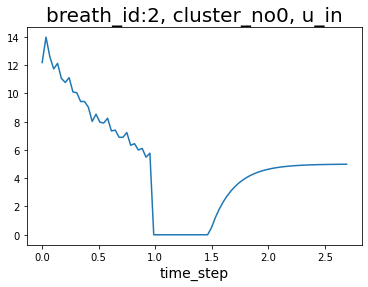

[0]


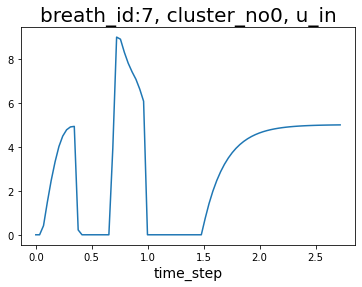

[0]


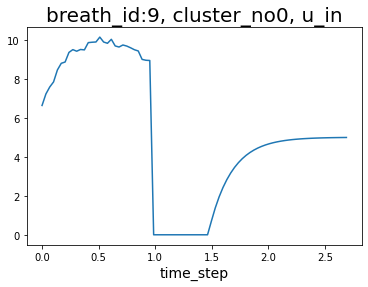

[0]


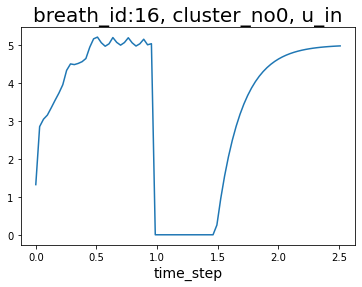

[0]


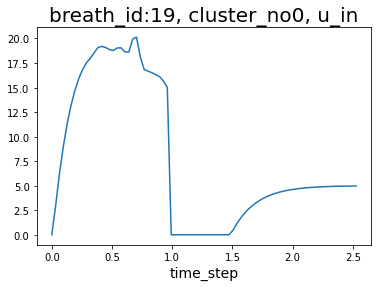

****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
clu_num 1
[1]


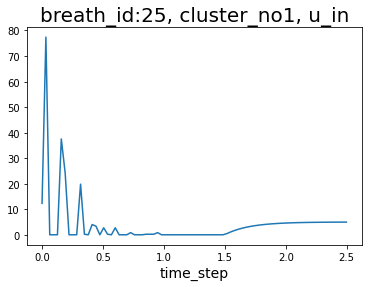

[1]


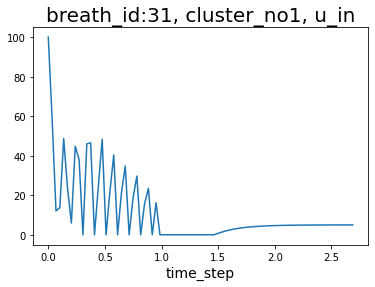

[1]


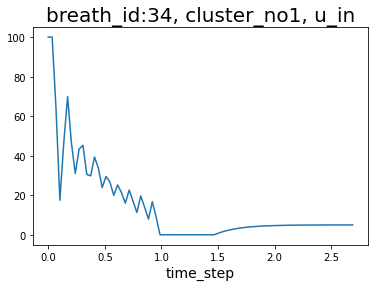

[1]


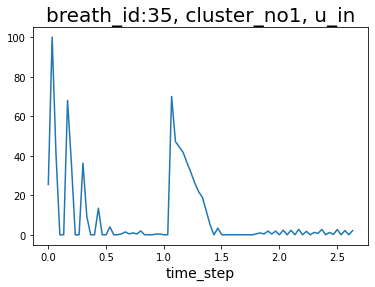

[1]


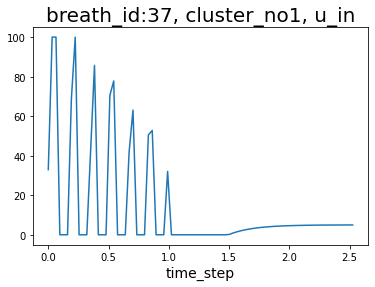

****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
clu_num 2
[2]


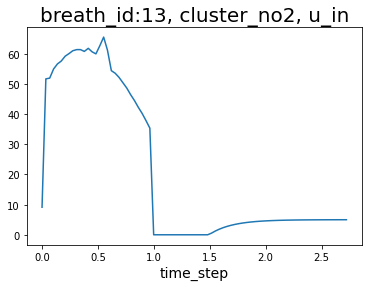

[2]


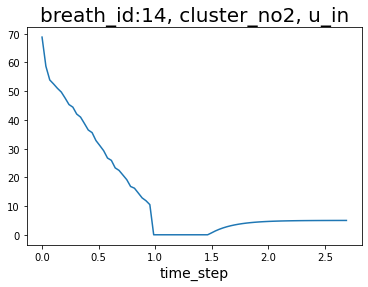

[2]


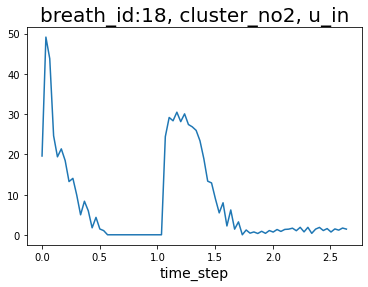

[2]


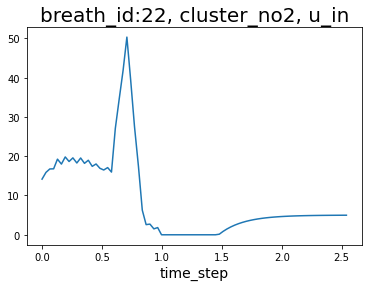

[2]


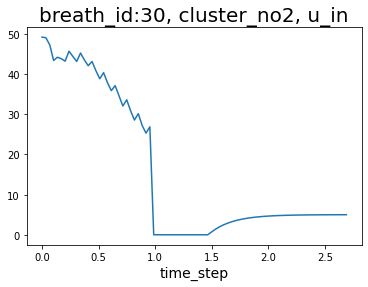

****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
clu_num 3
[3]


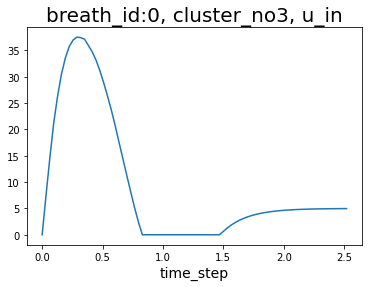

[3]


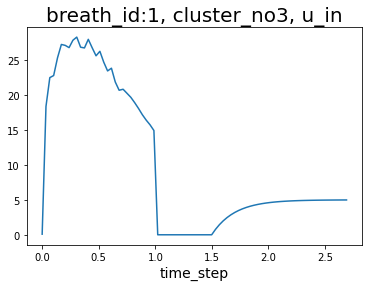

[3]


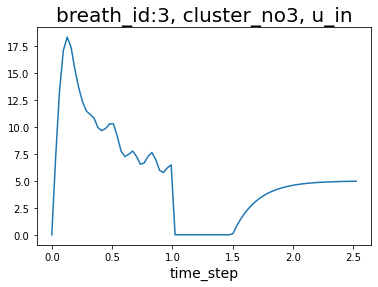

[3]


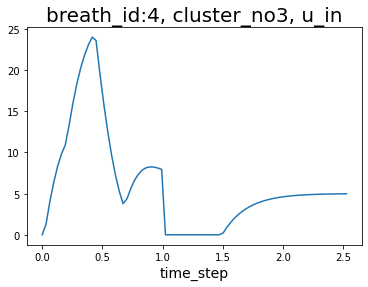

[3]


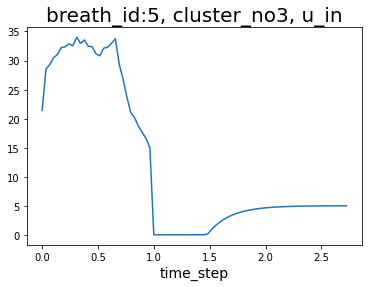

In [25]:
for clu_num in sorted(df_all_clu['cluster_no'].unique()):

  print('*'*100)
  print('*'*100)
  print('*'*100)
  print('*'*100)
  print('*'*100)
  print('clu_num', clu_num)

  breath_list = sorted(df_all_clu[
    (df_all_clu['cluster_no'] == clu_num)
  ]['breath_id'].unique())

  for breath_num in breath_list[:5]:
    tmp_df = df_all_clu[df_all_clu['breath_id'] == breath_num]
    print(tmp_df['cluster_no'].unique())

    plt.plot(tmp_df['time_step'], tmp_df['u_in'])
    plt.xlabel('time_step', fontsize = 14)
    plt.title(f'breath_id:{breath_num}, cluster_no{clu_num}, u_in', fontsize = 20)
    plt.show()

In [21]:
breath_id_list = grouped_df_all['breath_id']

In [22]:
len(breath_id_list)

125750

In [23]:
len(set(breath_id_list))

125750

In [24]:
grouped_df_all[['breath_id', 'train_test', 'cluster_no']].to_csv('/content/drive/MyDrive/output/kaggle_google_brain_ventilator_pressure/cluster_no.csv', index = False)